# 🧺 Análise de Cesta - Algoritmo FP Growth

### 🔣 Dicionário de Dados

**Legenda das Colunas da Tabela de Regras de Associação**

* **`antecedents`**:
    * O(s) código(s) do(s) produto(s) no lado esquerdo da regra (item X em "SE compra X...").
    * Tipo: Texto (object) ou Número (int64), idealmente tratado como Texto.

* **`consequents`**:
    * O(s) código(s) do(s) produto(s) no lado direito da regra (item Y em "...ENTÃO compra Y").
    * Tipo: Texto (object) ou Número (int64), idealmente tratado como Texto.

* **`antecedent support`**:
    * Frequência/proporção de transações que contêm o antecedente (X). `P(X)`.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`consequent support`**:
    * Frequência/proporção de transações que contêm o consequente (Y). `P(Y)`.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`support`**:
    * Frequência/proporção de transações que contêm *tanto* o antecedente (X) *quanto* o consequente (Y). `P(X e Y)`.
    * Indica a popularidade geral da *combinação* X e Y.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`confidence`**:
    * Probabilidade de encontrar o consequente (Y) em uma transação, *dado que* ela já contém o antecedente (X). `P(Y | X)`.
    * Mede a *confiabilidade* ou força preditiva da regra na direção X -> Y.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`lift`**:
    * Mede quantas vezes a presença de X *aumenta* a probabilidade de comprar Y, comparado à probabilidade normal de comprar Y. `Conf(X->Y) / Sup(Y)`.
    * Lift > 1 indica associação positiva (interessante); Lift = 1 indica independência; Lift < 1 indica associação negativa.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal (ex: 2 casas).*

* **`representativity`**: (Atenção: Métrica menos padronizada, pode ter definições variadas)
    * Tenta medir quão "representativa" é a regra ou a dependência encontrada, possivelmente comparando métricas observadas com esperadas.
    * *Verificar a documentação da biblioteca usada ou a fórmula específica para interpretação precisa.*
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`leverage`**:
    * Mede a diferença entre a frequência observada de X e Y juntos e a frequência esperada se fossem independentes. `Sup(X,Y) - Sup(X)*Sup(Y)`.
    * Valores > 0 indicam que aparecem juntos mais que o esperado.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`conviction`**:
    * Mede o grau de "implicação" da regra. Alto valor sugere que o consequente depende fortemente do antecedente. `(1-Sup(Y))/(1-Conf(X->Y))`.
    * Pode ser muito alto ou infinito.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`zhangs_metric`**:
    * Métrica robusta (varia de -1 a +1) que mede a associação levando em conta suporte e confiança, sem ser afetada pela popularidade isolada.
    * Valores próximos de +1 indicam forte associação positiva.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`jaccard`**:
    * Coeficiente de Jaccard: similaridade entre os conjuntos de transações contendo X e Y. `Sup(X,Y) / (Sup(X)+Sup(Y)-Sup(X,Y))`.
    * Valor entre 0 e 1 (pode ser visto como %).
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal ou Percentual (%).*

* **`certainty`**:
    * Mede o ganho de "certeza" proporcionado pela regra. `(Conf(X->Y) - Sup(Y)) / (1 - Sup(Y))`.
    * Varia de -1 a 1.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`kulczynski`**:
    * Média das confianças nas duas direções: `0.5 * (Conf(X->Y) + Conf(Y->X))`.
    * Valor entre 0 e 1 (pode ser visto como %).
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal ou Percentual (%).*

* **`Nomes_Antecedents`**:
    * O(s) nome(s) legível(is) do(s) produto(s) antecedente(s).
    * Tipo: Texto (object).

* **`Nomes_Consequents`**:
    * O(s) nome(s) legível(is) do(s) produto(s) consequente(s).
    * Tipo: Texto (object).


### 📚 Packages

In [1]:
import polars as pl
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, fpgrowth
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.ticker as mtick
import warnings 
import time     
import os
import pickle 

### 🎲 Dataset

- Dados extraídos do Kaggle - [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

In [2]:
orders = pl.read_csv("../data/olist_orders_dataset.csv")
order_items = pl.read_csv("../data/olist_order_items_dataset.csv")
products = pl.read_csv("../data/olist_products_dataset.csv")

In [4]:
order_items.schema

OrderedDict([('order_id', String),
             ('order_item_id', Int64),
             ('product_id', String),
             ('seller_id', String),
             ('shipping_limit_date', String),
             ('price', Float64),
             ('freight_value', Float64)])

In [5]:
orders.schema

OrderedDict([('order_id', String),
             ('customer_id', String),
             ('order_status', String),
             ('order_purchase_timestamp', String),
             ('order_approved_at', String),
             ('order_delivered_carrier_date', String),
             ('order_delivered_customer_date', String),
             ('order_estimated_delivery_date', String)])

In [6]:
products.schema

OrderedDict([('product_id', String),
             ('product_category_name', String),
             ('product_name_lenght', Int64),
             ('product_description_lenght', Int64),
             ('product_photos_qty', Int64),
             ('product_weight_g', Int64),
             ('product_length_cm', Int64),
             ('product_height_cm', Int64),
             ('product_width_cm', Int64)])

### 🧩 E.D.A

In [3]:
orders.head()

order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
str,str,str,str,str,str,str,str
"""e481f51cbdc546…","""9ef432eb625129…","""delivered""","""2017-10-02 10:…","""2017-10-02 11:…","""2017-10-04 19:…","""2017-10-10 21:…","""2017-10-18 00:…"
"""53cdb2fc8bc7dc…","""b0830fb4747a6c…","""delivered""","""2018-07-24 20:…","""2018-07-26 03:…","""2018-07-26 14:…","""2018-08-07 15:…","""2018-08-13 00:…"
"""47770eb9100c2d…","""41ce2a54c0b03b…","""delivered""","""2018-08-08 08:…","""2018-08-08 08:…","""2018-08-08 13:…","""2018-08-17 18:…","""2018-09-04 00:…"
"""949d5b44dbf5de…","""f88197465ea792…","""delivered""","""2017-11-18 19:…","""2017-11-18 19:…","""2017-11-22 13:…","""2017-12-02 00:…","""2017-12-15 00:…"
"""ad21c59c0840e6…","""8ab97904e6daea…","""delivered""","""2018-02-13 21:…","""2018-02-13 22:…","""2018-02-14 19:…","""2018-02-16 18:…","""2018-02-26 00:…"


In [4]:
order_items.head()

order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
str,i64,str,str,str,f64,f64
"""00010242fe8c5a…",1,"""4244733e06e7ec…","""48436dade18ac8…","""2017-09-19 09:…",58.9,13.29
"""00018f77f2f032…",1,"""e5f2d52b802189…","""dd7ddc04e1b6c2…","""2017-05-03 11:…",239.9,19.93
"""000229ec398224…",1,"""c777355d18b72b…","""5b51032eddd242…","""2018-01-18 14:…",199.0,17.87
"""00024acbcdf0a6…",1,"""7634da152a4610…","""9d7a1d34a50524…","""2018-08-15 10:…",12.99,12.79
"""00042b26cf59d7…",1,"""ac6c3623068f30…","""df560393f3a51e…","""2017-02-13 13:…",199.9,18.14


In [5]:
products.head()

product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
str,str,i64,i64,i64,i64,i64,i64,i64
"""1e9e8ef04dbcff…","""perfumaria""",40,287,1,225,16,10,14
"""3aa071139cb16b…","""artes""",44,276,1,1000,30,18,20
"""96bd76ec881037…","""esporte_lazer""",46,250,1,154,18,9,15
"""cef67bcfe19066…","""bebes""",27,261,1,371,26,4,26
"""9dc1a7de274444…","""utilidades_dom…",37,402,4,625,20,17,13


- Shape de cada DF

In [5]:
print(f"\n Ordem: {orders.shape}\n Ordem Produtos: {orders.shape} \n Produtos: {orders.shape}")


 Ordem: (99441, 8)
 Ordem Produtos: (99441, 8) 
 Produtos: (99441, 8)


- Garantindo que os valores order_id e product_id apareçam apenas uma vez

In [3]:
# Parâmetros (definir ou pegar de célula anterior)
STATUS_VALIDOS = ['delivered'] # Define quais status de pedido considerar

print("--- Iniciando Junção e Preparação Inicial (Polars) ---")
print(f"Filtrando por status: {STATUS_VALIDOS}")

# Assumindo que 'orders' e 'order_items' já estão carregados das células anteriores
try:
    # 1. Join orders e order_items (Selecionando só o necessário de 'orders')
    print("Passo 1: Juntando orders e order_items...")
    order_details = order_items.join(
        orders.select(['order_id', 'order_status']), # Seleciona só colunas necessárias de 'orders'
        on='order_id',
        how='inner'
    )
    print(f"Shape após join: {order_details.shape}")

    # 2. Filtrar por Status
    print("Passo 2: Filtrando por status do pedido...")
    order_details_filtered = order_details.filter(pl.col('order_status').is_in(STATUS_VALIDOS))
    print(f"Shape após filtro de status: {order_details_filtered.shape}")

    # 3. Selecionar Colunas Chave
    print("Passo 3: Selecionando order_id e product_id...")
    baskets_raw = order_details_filtered.select(['order_id', 'product_id'])

    # 4. Remover Duplicatas (mesmo produto no mesmo pedido)
    print("Passo 4: Removendo produtos duplicados dentro do mesmo pedido...")
    # Garantir que product_id seja string antes do unique, caso não tenha sido feito antes
    baskets_unique = baskets_raw.with_columns(pl.col('product_id').cast(pl.Utf8)).unique(subset=['order_id', 'product_id'], keep='first')
    # (Nome da variável ajustado para 'baskets_unique' para clareza, mas pode manter 'basket_items_unique')
    basket_items_unique = baskets_unique # Mantendo nome original para consistência com o resto do fluxo
    print(f"Shape final de 'basket_items_unique' (Polars): {basket_items_unique.shape}")

    print("\n--- Preparação Inicial Concluída ---")
    print("DataFrame 'basket_items_unique' (Polars) pronto para a próxima etapa (agrupamento em lista).")
    # print(basket_items_unique.head()) # Descomente para verificar

except Exception as e:
    print(f"Erro durante a preparação inicial: {e}")
    basket_items_unique = None # Indicar erro ainda é útil

# Verificar se a etapa funcionou antes de prosseguir para a próxima célula
if basket_items_unique is None or basket_items_unique.height == 0:
    print("\nAviso: A preparação inicial falhou ou não resultou em dados.")
    print("Verifique os filtros, joins e a execução das células anteriores.")

--- Iniciando Junção e Preparação Inicial (Polars) ---
Filtrando por status: ['delivered']
Passo 1: Juntando orders e order_items...
Shape após join: (112650, 8)
Passo 2: Filtrando por status do pedido...
Shape após filtro de status: (110197, 8)
Passo 3: Selecionando order_id e product_id...
Passo 4: Removendo produtos duplicados dentro do mesmo pedido...
Shape final de 'basket_items_unique' (Polars): (100196, 2)

--- Preparação Inicial Concluída ---
DataFrame 'basket_items_unique' (Polars) pronto para a próxima etapa (agrupamento em lista).


In [4]:
type(basket_items_unique)

polars.dataframe.frame.DataFrame

In [5]:
print("\n--- Iniciando Passo 5.5: Filtrar Produtos Pouco Frequentes ---")

# !!! AJUSTE ESTE VALOR CONFORME NECESSÁRIO !!!
# Comece com um valor alto para tentar resolver o MemoryError (ex: 100, 150, 200)
min_item_frequency = 10

basket_items_filtered = None # Inicializar

# Verificar se basket_items_unique existe da célula anterior
if 'basket_items_unique' in locals() and basket_items_unique is not None and basket_items_unique.height > 0:
    try:
        print(f"Calculando frequência dos produtos (limiar >= {min_item_frequency})...")
        # Conta em quantas cestas únicas cada produto aparece
        item_counts = basket_items_unique.group_by('product_id').agg(
            pl.count().alias('counts')
        )
        # Seleciona os product_ids que atendem à frequência mínima
        frequent_items_ids = item_counts.filter(
            pl.col('counts') >= min_item_frequency
        )['product_id']

        # Filtra o DataFrame principal
        basket_items_filtered = basket_items_unique.filter(
            pl.col('product_id').is_in(frequent_items_ids)
        )
        num_produtos_originais = basket_items_unique['product_id'].n_unique()
        num_produtos_restantes = frequent_items_ids.shape[0]
        print(f"Produtos únicos originais: {num_produtos_originais}")
        print(f"Produtos únicos restantes após filtro (freq >= {min_item_frequency}): {num_produtos_restantes}")
        print(f"Itens restantes nas cestas após filtro: {basket_items_filtered.shape[0]}")

        if basket_items_filtered.height == 0 :
             print("\nAviso: Nenhum item restou após esta filtragem de frequência.")

    except Exception as e:
        print(f"Erro durante a filtragem de frequência: {e}")
        basket_items_filtered = None

else:
    print("ERRO ou Aviso: 'basket_items_unique' não está disponível ou está vazio.")
    print("A filtragem de frequência não pode ser aplicada.")

if basket_items_filtered is None:
     print("\nVariável 'basket_items_filtered' não foi criada devido a erro.")
else:
     print("\nVariável 'basket_items_filtered' (Polars) criada com sucesso.")
     print("Use esta variável na próxima célula.")
print("--- Fim Passo 5.5 ---")


--- Iniciando Passo 5.5: Filtrar Produtos Pouco Frequentes ---
Calculando frequência dos produtos (limiar >= 10)...
Produtos únicos originais: 32216
Produtos únicos restantes após filtro (freq >= 10): 1643
Itens restantes nas cestas após filtro: 42370

Variável 'basket_items_filtered' (Polars) criada com sucesso.
Use esta variável na próxima célula.
--- Fim Passo 5.5 ---


C:\Users\gean.cruz.maitha_tra\AppData\Local\Temp\ipykernel_20824\685365181.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('counts')


### Agrupando os valores por transação - Criando uma lista de listas: 
- Não vamos usar Polars nessa etapa devido o TransactionEncoder não ser compatível com Polars. 

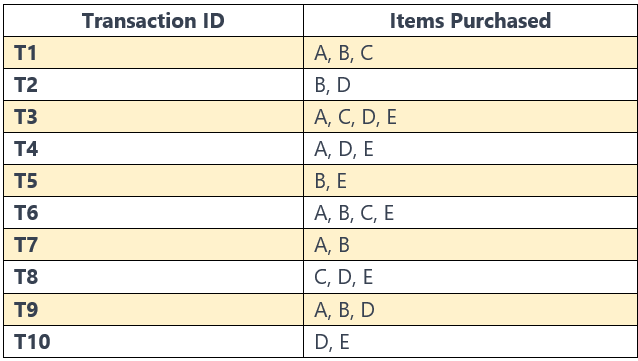

In [6]:
print("\n--- Iniciando Passo 6: Agrupamento em Lista (Pandas Workaround) ---")
transactions_list = None # Inicializar variável

# Tenta executar a conversão e agrupamento, usando 'basket_items_filtered'
try:
    # Verifica se a variável do passo anterior existe e não está vazia
    if 'basket_items_filtered' in locals() and basket_items_filtered is not None and basket_items_filtered.height > 0:

        # 6.1 Converter o DataFrame Polars 'basket_items_filtered' para Pandas <<< MUDANÇA AQUI
        print("Convertendo para Pandas (dados filtrados)...")
        basket_items_unique_pd = basket_items_filtered.to_pandas() # <<< USA INPUT FILTRADO
        print(f"Convertido para Pandas. Shape: {basket_items_unique_pd.shape}")

        # 6.2 Aplicar o groupby do Pandas para obter a lista de listas
        print("Agrupando produtos por pedido (Pandas)...")
        transactions_list = basket_items_unique_pd.groupby('order_id')['product_id'].apply(list).tolist()
        print(f"Agrupamento com Pandas concluído. Número de cestas (listas): {len(transactions_list)}")
        # print(transactions_list[:3])

    elif 'basket_items_filtered' not in locals() or basket_items_filtered is None:
         print("ERRO: A variável 'basket_items_filtered' não foi encontrada.")
         print("Certifique-se de que a célula anterior (Passo 5.5) foi executada com sucesso.")
         transactions_list = None
    else: # basket_items_filtered está vazio
         print("Aviso: DataFrame 'basket_items_filtered' está vazio após filtros. Não há cestas para agrupar.")
         transactions_list = [] # Define como lista vazia

except NameError:
    # Captura o erro se 'basket_items_filtered' não existir por algum motivo
    print("ERRO: A variável 'basket_items_filtered' não foi encontrada (NameError).")
    print("Certifique-se de que a célula anterior que a cria foi executada com sucesso.")
    transactions_list = None

except Exception as e:
    # Captura outros erros durante a conversão ou agrupamento
    print(f"Erro durante o Passo 6 (Conversão/Agrupamento Pandas): {e}")
    transactions_list = None

# Verificar se a etapa produziu uma lista válida antes de prosseguir
if transactions_list is None or len(transactions_list) == 0:
    print("\nAviso: Agrupamento falhou ou não resultou em transações. Verifique a execução e os dados.")
else:
    print("\nVariável 'transactions_list' (Lista de Listas Python) criada com sucesso.")
    print("Pronta para a próxima etapa (TransactionEncoder).")


--- Iniciando Passo 6: Agrupamento em Lista (Pandas Workaround) ---
Convertendo para Pandas (dados filtrados)...
Convertido para Pandas. Shape: (42370, 2)
Agrupando produtos por pedido (Pandas)...
Agrupamento com Pandas concluído. Número de cestas (listas): 41662

Variável 'transactions_list' (Lista de Listas Python) criada com sucesso.
Pronta para a próxima etapa (TransactionEncoder).


In [7]:
type(transactions_list)

list

### TransactionEncoder - Transformando a lista no formato matriz "one-hot-encoded"
- Com a lista de listas de produtos por pedido criada, iniciamos esse próximo passo; 
- As funções do MLxtend (no caso a fpgrowth), espera os dados no formato elencado no título. 

In [8]:
df_encoded_pd = None # Inicializar a variável de resultado

# Verificar se transactions_list existe e foi criada corretamente na célula anterior
if 'transactions_list' in locals() and transactions_list is not None and len(transactions_list) > 0:
    try:
        print("Instanciando e aplicando TransactionEncoder...")
        # 7.1 Instanciar o encoder
        te = TransactionEncoder()

        # 7.2 Treinar (fit) para encontrar todos os itens únicos e transformar (transform)
        # O resultado te_ary é um array NumPy booleano
        te_ary = te.fit(transactions_list).transform(transactions_list)
        print("Matriz booleana criada.")

        # 8.1 Criar DataFrame Pandas a partir do array booleano
        # As colunas serão os product_ids únicos encontrados pelo te.fit()
        df_encoded_pd = pd.DataFrame(te_ary, columns=te.columns_)
        print("\nDataFrame one-hot encoded (Pandas) criado com sucesso.")
        print(f"Shape: {df_encoded_pd.shape}")
        print(f"Número de cestas (linhas): {df_encoded_pd.shape[0]}")
        print(f"Número de produtos únicos (colunas): {df_encoded_pd.shape[1]}")
        print("\nExemplo das primeiras linhas (head):")
        print(df_encoded_pd.head())
        print("\nEste DataFrame está pronto para ser usado no FP-Growth.")

    except Exception as e:
        print(f"Erro durante a aplicação do TransactionEncoder ou criação do DataFrame: {e}")
        df_encoded_pd = None # Indica que houve erro

else:
    print("ERRO: 'transactions_list' não foi encontrada, está vazia ou não foi criada corretamente.")
    print("Execute a célula anterior (Passo 6) com sucesso primeiro.")

# Verificar se a etapa funcionou antes de prosseguir para a próxima célula
if df_encoded_pd is None or df_encoded_pd.empty:
    print("\nAviso: Falha ao criar DataFrame codificado. Análise não pode prosseguir.")
else:
     print("\nDataFrame 'df_encoded_pd' gerado com sucesso.")

Instanciando e aplicando TransactionEncoder...
Matriz booleana criada.

DataFrame one-hot encoded (Pandas) criado com sucesso.
Shape: (41662, 1643)
Número de cestas (linhas): 41662
Número de produtos únicos (colunas): 1643

Exemplo das primeiras linhas (head):
   001b72dfd63e9833e8c02742adf472e3  005030ef108f58b46b78116f754d8d38  \
0                             False                             False   
1                             False                             False   
2                             False                             False   
3                             False                             False   
4                             False                             False   

   00878d953636afec00d3e85d55a12e7f  008cff0e5792219fae03e570f980b330  \
0                             False                             False   
1                             False                             False   
2                             False                             False   
3       

#### 🚨 Alerta - Matriz Gigante! 
- Devido o processo de TransactionEncoder criar uma matriz gigante, devemos tomar cuidados com o processamento da mesma; 
- Pode ocorrer esgotamento do processamento da máquina, acarretando na falta de memória alocada para o processo; 
- Em casos extremos, precisamos realizar uma redução de dimensionalidade, seguindo boas práticas para não perder tanta informação. 

--> Neste caso, eu fiz uma redução de dimensão no passo x, onde eu filtrei os produtos de baixa frequência (raros), que apenas consumiria memória e não agregaria nada na análise. 

In [9]:
df_encoded_pd.shape

(41662, 1643)

### FP-Growth - Encontrando os frequent_itemsets

#### 🥒 [Pickle](https://docs.python.org/3/library/pickle.html) - Conservando as variáveis após a execução da FP Growth

In [11]:
# --- Parâmetros ---
min_support_valor = 0.0001 # O valor baixo que estava funcionando antes ou o que você quer testar
pickle_filename_itemsets = f'frequent_itemsets_support_{min_support_valor}.pkl' # Nome do arquivo inclui o suporte
print(f"Buscando/Gerando itemsets frequentes com min_support = {min_support_valor}")
print(f"Arquivo pickle para itemsets: {pickle_filename_itemsets}")

frequent_itemsets = None # Inicializar

# Verificar se df_encoded_pd existe da célula anterior
if 'df_encoded_pd' in locals() and df_encoded_pd is not None and not df_encoded_pd.empty:

    # 1. Tentar Carregar do Pickle
    if os.path.exists(pickle_filename_itemsets):
        print(f"\nEncontrado arquivo pickle: {pickle_filename_itemsets}")
        print("Carregando 'frequent_itemsets'...")
        try:
            with open(pickle_filename_itemsets, 'rb') as f:
                frequent_itemsets = pickle.load(f)
            print(f"Carregamento do pickle bem-sucedido. {len(frequent_itemsets)} itemsets carregados.")
        except Exception as e:
            print(f"Erro ao carregar o arquivo pickle: {e}")
            print("Executando FP-Growth para gerar novamente...")
            frequent_itemsets = None # Resetar para garantir que fpgrowth rode

    # 2. Se não carregou do Pickle, Executar FP-Growth
    if frequent_itemsets is None:
        print(f"\nArquivo pickle não encontrado ou erro ao carregar. Executando fpgrowth (pode demorar)...")
        start_fpgrowth = time.time()
        try:
            # Executa o FP-Growth no DataFrame one-hot encoded
            frequent_itemsets = fpgrowth(df_encoded_pd, min_support=min_support_valor, use_colnames=True)
            end_fpgrowth = time.time()
            print(f"FP-Growth concluído em {end_fpgrowth - start_fpgrowth:.2f} segundos.")

            # 3. Salvar o resultado em Pickle (se encontrou algo)
            if not frequent_itemsets.empty:
                print(f"Salvando {len(frequent_itemsets)} 'frequent_itemsets' em {pickle_filename_itemsets}...")
                try:
                    with open(pickle_filename_itemsets, 'wb') as f:
                        pickle.dump(frequent_itemsets, f)
                    print("Arquivo pickle salvo com sucesso.")
                except Exception as e:
                    print(f"Erro ao salvar o arquivo pickle: {e}")
            else:
                print("Nenhum itemset frequente encontrado. Nenhum arquivo pickle foi salvo.")

        except MemoryError:
             print("\nERRO DE MEMÓRIA durante o FP-Growth.")
             print("Isso indica que mesmo com FP-Growth, a combinação de dados e min_support exige muita memória.")
             print("Considere aumentar 'MIN_ITEM_FREQUENCY' na célula de preparação de dados ou usar análise por categoria.")
             frequent_itemsets = pd.DataFrame() # DataFrame vazio para evitar erro adiante
        except Exception as e:
            print(f"Erro durante o FP-Growth: {e}")
            frequent_itemsets = pd.DataFrame()

    # 4. Verificar e Exibir Informações (do resultado carregado ou calculado)
    if frequent_itemsets is not None and not frequent_itemsets.empty:
        frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
        print(f"\nResultado final: {frequent_itemsets.shape[0]} itemsets frequentes.")
        max_len = frequent_itemsets['length'].max() if not frequent_itemsets.empty else 0
        num_multi_itemsets = len(frequent_itemsets[frequent_itemsets['length'] >= 2]) if not frequent_itemsets.empty else 0
        print(f"Tamanho máximo de itemset: {max_len}")
        print(f"Número de itemsets com mais de 1 item: {num_multi_itemsets}")

        if num_multi_itemsets > 0:
             print("\nDataFrame 'frequent_itemsets' pronto para a próxima etapa (association_rules).")
        else:
             print("\nAviso: Nenhum itemset com 2 ou mais itens encontrado. Não será possível gerar regras.")
             print("Tente diminuir o 'min_support_valor'.")
        # print(frequent_itemsets.sort_values('support', ascending=False).head()) # Descomente se quiser ver
    else:
        print("\nNenhum itemset frequente utilizável foi carregado ou gerado.")
        print("Verifique o 'min_support_valor' ou os dados de entrada.")

else:
    print("\nERRO: DataFrame 'df_encoded_pd' não foi criado ou está vazio na célula anterior.")
    print("Análise de FP-Growth não pode prosseguir.")

Buscando/Gerando itemsets frequentes com min_support = 0.0001
Arquivo pickle para itemsets: frequent_itemsets_support_0.0001.pkl

Arquivo pickle não encontrado ou erro ao carregar. Executando fpgrowth (pode demorar)...
FP-Growth concluído em 4.39 segundos.
Salvando 1662 'frequent_itemsets' em frequent_itemsets_support_0.0001.pkl...
Arquivo pickle salvo com sucesso.

Resultado final: 1662 itemsets frequentes.
Tamanho máximo de itemset: 2
Número de itemsets com mais de 1 item: 19

DataFrame 'frequent_itemsets' pronto para a próxima etapa (association_rules).


- Analisando se foi criado corretamente os conjuntos

In [12]:
print("\n--- Iniciando Análise do DataFrame 'frequent_itemsets' ---")

# --- Parâmetros (Deve ser o mesmo usado para gerar o pickle) ---
min_support_valor = 0.0001
pickle_filename_itemsets = f'frequent_itemsets_support_{min_support_valor}.pkl'

frequent_itemsets = None # Inicializar

# --- Carregar do Pickle ---
if os.path.exists(pickle_filename_itemsets):
    print(f"Carregando '{pickle_filename_itemsets}'...")
    try:
        with open(pickle_filename_itemsets, 'rb') as f:
            frequent_itemsets = pickle.load(f)
        print(f"Carregado com sucesso. Shape: {frequent_itemsets.shape}")

        # Verificar/Recalcular coluna 'length'
        if 'length' not in frequent_itemsets.columns:
             print("Recalculando coluna 'length'...")
             frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

    except Exception as e:
        print(f"Erro ao carregar pickle: {e}")
        frequent_itemsets = None
else:
    print(f"ERRO: Arquivo pickle '{pickle_filename_itemsets}' não encontrado.")
    print("Certifique-se de que a célula anterior (FP-Growth) foi executada com sucesso e salvou o arquivo.")

# --- Análises ---
if frequent_itemsets is not None and not frequent_itemsets.empty:

    print(f"\nAnálise do DataFrame 'frequent_itemsets':")

    # 1. Confirmação de Itemsets Múltiplos (CRUCIAL)
    max_len = frequent_itemsets['length'].max()
    num_multi_itemsets = len(frequent_itemsets[frequent_itemsets['length'] >= 2])
    print(f"\n1. Tamanho máximo de itemset encontrado: {max_len}")
    print(f"   Número de itemsets com 2 ou mais itens: {num_multi_itemsets}")
    if num_multi_itemsets == 0:
        print("   >>> ALERTA: NENHUM itemset com 2+ itens foi encontrado! <<<")
        print("   >>> Não será possível gerar regras de associação. Considere diminuir 'min_support' na célula FP-Growth. <<<")
    else:
        print("   >>> OK: Itemsets com 2+ itens encontrados, regras podem ser geradas.")

        # 2. Distribuição do Tamanho dos Itemsets
        print("\n2. Contagem de Itemsets por Tamanho:")
        print(frequent_itemsets['length'].value_counts().sort_index())

        # 3. Itemsets Mais Frequentes (Maior Suporte)
        print("\n3. Top 10 Itemsets Mais Frequentes:")
        # Mostra os 10 conjuntos (incluindo itens únicos) que mais aparecem
        print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))

        # 4. Itemsets Mais Longos (se houver)
        if max_len > 1:
            print(f"\n4. Top 10 Itemsets Mais Longos:")
            # Mostra os 10 conjuntos com mais itens
            print(frequent_itemsets.sort_values(by='length', ascending=False).head(10))
        else:
            print("\n4. Nenhum itemset com mais de 1 item para mostrar como 'mais longo'.")

        # 5. Itemsets Menos Frequentes (Próximos ao Limiar)
        print(f"\n5. Top 10 Itemsets MENOS Frequentes (Suporte próximo a {min_support_valor}):")
        # Mostra os conjuntos que quase não atingiram o suporte mínimo
        print(frequent_itemsets.sort_values(by='support', ascending=True).head(10))

        print("\n--- Análise de 'frequent_itemsets' Concluída ---")
        print("Se houver itemsets com length >= 2, o próximo passo é gerar regras com association_rules().")

else:
    print("\nDataFrame 'frequent_itemsets' está vazio ou não foi carregado. Análise não pode continuar.")


--- Iniciando Análise do DataFrame 'frequent_itemsets' ---
Carregando 'frequent_itemsets_support_0.0001.pkl'...
Carregado com sucesso. Shape: (1662, 2)
Recalculando coluna 'length'...

Análise do DataFrame 'frequent_itemsets':

1. Tamanho máximo de itemset encontrado: 2
   Número de itemsets com 2 ou mais itens: 19
   >>> OK: Itemsets com 2+ itens encontrados, regras podem ser geradas.

2. Contagem de Itemsets por Tamanho:
length
1    1643
2      19
Name: count, dtype: int64

3. Top 10 Itemsets Mais Frequentes:
      support                            itemsets  length
2    0.010945  (99a4788cb24856965c36a24e339b6058)       1
91   0.010201  (aca2eb7d00ea1a7b8ebd4e68314663af)       1
167  0.008449  (422879e10f46682990de24d770e7f83d)       1
52   0.007513  (d1c427060a0f73f6b889a5c7c61f2ac4)       1
45   0.007417  (389d119b48cf3043d311335e499d9c6b)       1
41   0.007297  (53b36df67ebb7c41585e8d54d6772e08)       1
3    0.006985  (368c6c730842d78016ad823897a372db)       1
135  0.006889  (53

### Gerando Regras de Associação 

In [13]:
print("\n--- Iniciando Passo 10: Geração das Regras de Associação ---")
rules = pd.DataFrame() # Inicializar DataFrame vazio

# Verificar se frequent_itemsets existe e contém itemsets múltiplos
if ('frequent_itemsets' in locals() and
    frequent_itemsets is not None and
    not frequent_itemsets.empty and
    len(frequent_itemsets[frequent_itemsets['length'] >= 2]) > 0):

    # --- Parâmetros para geração de regras ---
    # !!! AJUSTE A MÉTRICA E O LIMIAR CONFORME NECESSÁRIO !!!
    metric = "lift" # Métrica principal para filtrar ('lift' ou 'confidence')
    min_threshold_valor = 1 # Limiar mínimo para a métrica (lift >= 1 ou confidence >= 0.x)
    print(f"Gerando regras com base em '{metric}' >= {min_threshold_valor}...")

    try:
        # Gerar as regras
        rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold_valor)
        print(f"Regras geradas. Encontradas {rules.shape[0]} regras.")

        if not rules.empty:
            # Ordenar por lift ou confiança para ver as mais fortes primeiro
            rules = rules.sort_values(by=metric, ascending=False)
            print("\nExemplo de regras encontradas (Top 10):")
            print(rules.head(10))
            print("\nDataFrame 'rules' pronto para a próxima etapa (adicionar nomes/categorias).")
        else:
            print("\nNenhuma regra encontrada que atenda ao critério de métrica/limiar.")
            print(f"Tente usar um limiar ('min_threshold_valor') mais baixo para a métrica '{metric}' ou outra métrica.")

    except Exception as e:
        print(f"Erro durante a geração de regras: {e}")
        rules = pd.DataFrame() # Garante que 'rules' seja um DF vazio em caso de erro

else:
    print("ERRO ou Aviso: 'frequent_itemsets' não contém itemsets com 2 ou mais itens.")
    print("Não é possível gerar regras.")

# Verificar resultado antes de prosseguir
if rules.empty:
    print("\nAviso: Nenhuma regra de associação foi gerada com os parâmetros atuais.")


--- Iniciando Passo 10: Geração das Regras de Associação ---
Gerando regras com base em 'lift' >= 1...
Regras geradas. Encontradas 38 regras.

Exemplo de regras encontradas (Top 10):
                           antecedents                         consequents  \
34  (ad0a798e7941f3a5a2fb8139cb62ad78)  (946344697156947d846d27fe0d503033)   
35  (946344697156947d846d27fe0d503033)  (ad0a798e7941f3a5a2fb8139cb62ad78)   
36  (5fc3e6a4b52b0c414458104ed4037f1c)  (5d790355cbeded0cd60e25cbc4c527a2)   
37  (5d790355cbeded0cd60e25cbc4c527a2)  (5fc3e6a4b52b0c414458104ed4037f1c)   
30  (5b8a5a9417210b1b84b67b9a7aefb935)  (e5ae72c62ebfa708624f5029d609b160)   
31  (e5ae72c62ebfa708624f5029d609b160)  (5b8a5a9417210b1b84b67b9a7aefb935)   
17  (060cb19345d90064d1015407193c233d)  (98d61056e0568ba048e5d78038790e77)   
16  (98d61056e0568ba048e5d78038790e77)  (060cb19345d90064d1015407193c233d)   
33  (dbb67791e405873b259e4656bf971246)  (18486698933fbb64af6c0a255f7dd64c)   
32  (18486698933fbb64af6c0a255f7dd64

### Gráfico de Grafos das Associações de Produtos

Passo 11: Adicionando nomes de categoria às regras...
Categorias adicionadas.

Preparando dados e criando o grafo...
Grafo criado com 6 nós (categorias) e 7 arestas (regras).
Calculando layout...
Desenhando o grafo...


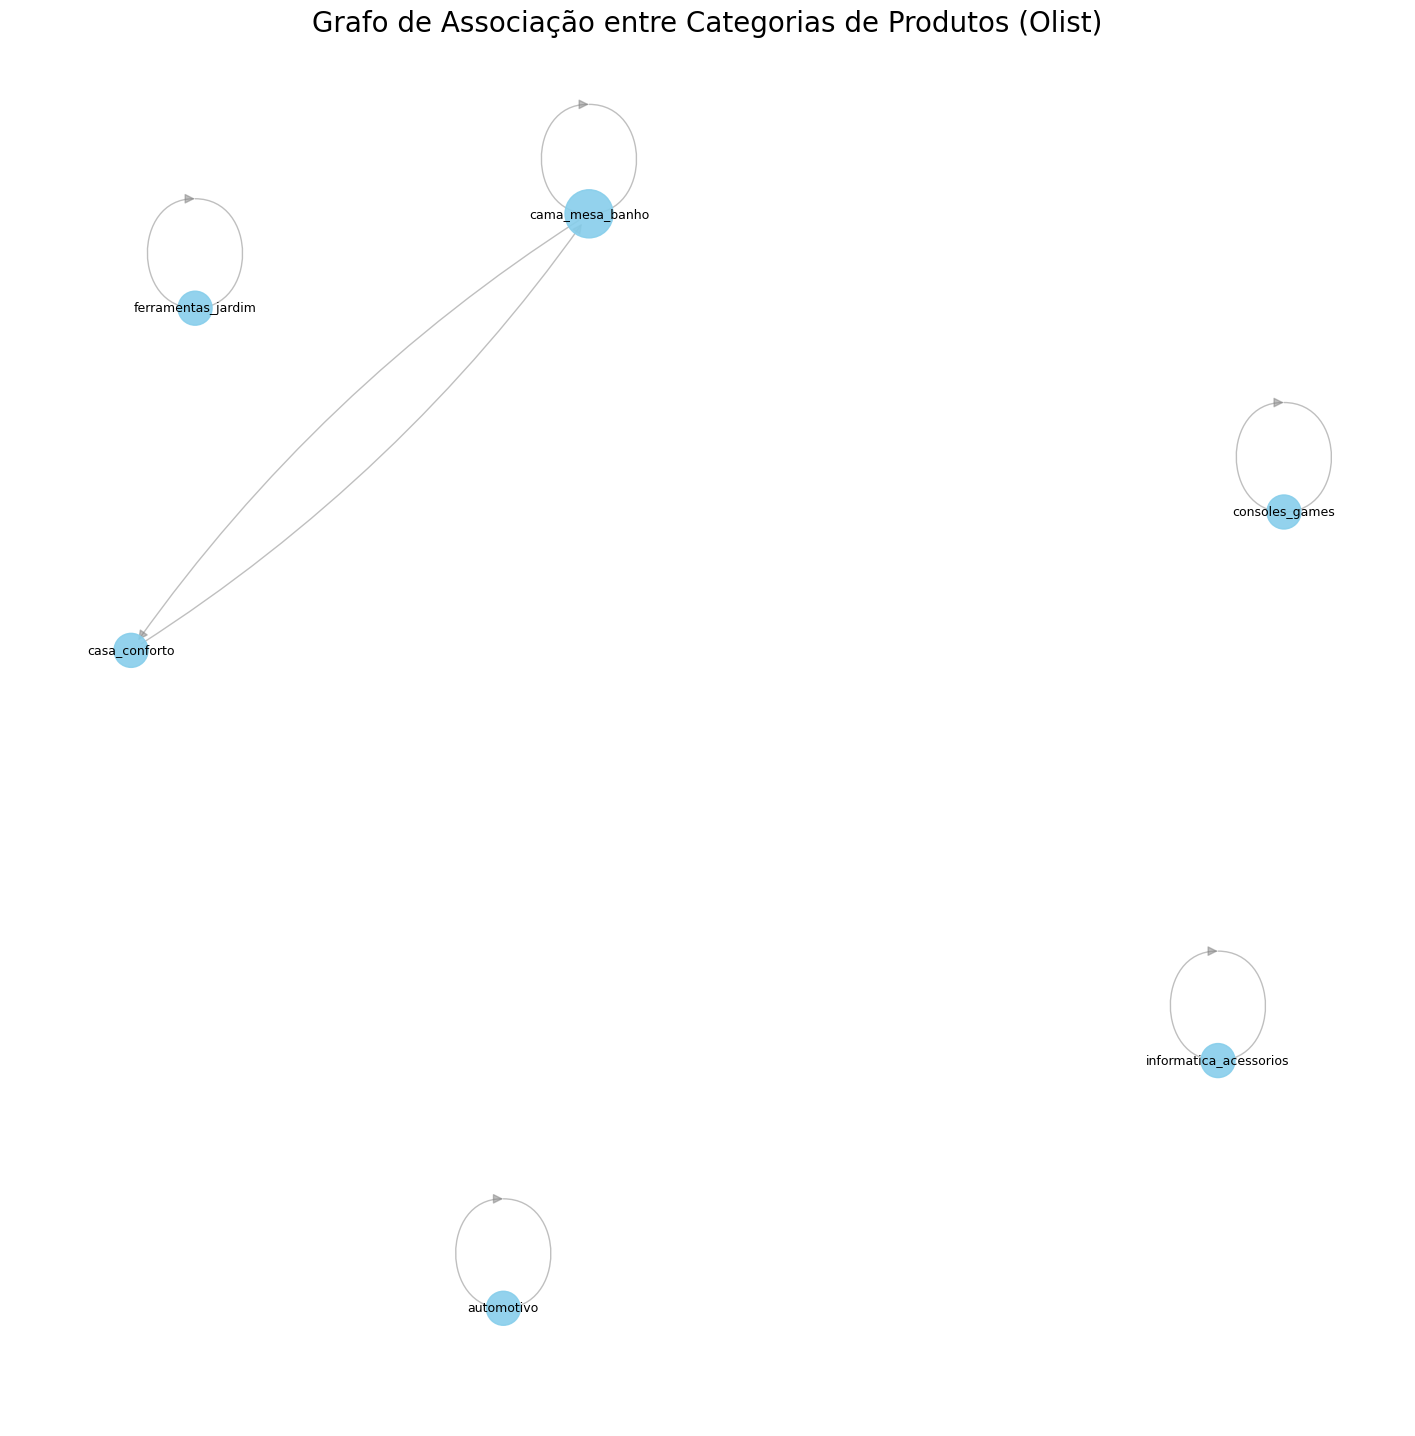

In [14]:
if ('rules' in locals() and not rules.empty and
    'products' in locals() and products is not None): # Checa products também

    try:
        # --- 11. Adicionar Nomes de Categoria (Revisado) ---
        print("Passo 11: Adicionando nomes de categoria às regras...")

        # Criar mapa de categorias (Polars para Pandas para Dict)
        # Tratar nulos na categoria ANTES de criar o dict
        mapa_categorias = products.select(['product_id', 'product_category_name'])\
                                  .fill_null("Desconhecida")\
                                  .with_columns(pl.col('product_id').cast(pl.Utf8))\
                                  .unique(subset=['product_id'], keep='first')\
                                  .to_pandas()\
                                  .set_index('product_id')['product_category_name']\
                                  .to_dict()

        # Função auxiliar para obter UMA categoria representativa do frozenset
        def get_category_from_itemset(itemset, mapa):
            # Pega a categoria do primeiro item do set como representante
            # Funciona bem para regras A->B, C->D, etc.
            # Para regras {A,B}->C, pegaria a categoria de A ou B.
            first_item = next(iter(itemset), None) # Pega o primeiro item ou None se vazio
            return mapa.get(first_item, f"Cat({first_item})?") if first_item else "Desconhecido"

        # Aplicar para criar colunas de categoria
        rules['Categoria_Antecedent'] = rules['antecedents'].apply(lambda x: get_category_from_itemset(x, mapa_categorias))
        rules['Categoria_Consequent'] = rules['consequents'].apply(lambda x: get_category_from_itemset(x, mapa_categorias))
        print("Categorias adicionadas.")

        # --- Preparar Dados e Criar Grafo ---
        print("\nPreparando dados e criando o grafo...")
        # Usar as categorias como nós. Selecionar colunas para o grafo.
        rules_for_graph = rules[['Categoria_Antecedent', 'Categoria_Consequent', 'lift', 'confidence']].copy()

        # Opcional: Remover regras onde antecedente e consequente são da mesma categoria?
        # rules_for_graph = rules_for_graph[rules_for_graph['Categoria_Antecedent'] != rules_for_graph['Categoria_Consequent']]
        # print(f"Mantidas {len(rules_for_graph)} regras intercategorias para o grafo.")

        if rules_for_graph.empty:
             print("Nenhuma regra restante após filtros para plotar o grafo.")
        else:
            # Criar grafo direcionado (A -> B)
            G = nx.from_pandas_edgelist(
                rules_for_graph,
                source='Categoria_Antecedent',
                target='Categoria_Consequent',
                edge_attr=['lift', 'confidence'], # Atributos da aresta
                create_using=nx.DiGraph()
            )
            print(f"Grafo criado com {G.number_of_nodes()} nós (categorias) e {G.number_of_edges()} arestas (regras).")

            # Calcular grau total (entrada + saída) para tamanho do nó
            degrees = {node: G.in_degree(node) + G.out_degree(node) for node in G.nodes()}
            node_sizes = [degrees.get(node, 1) * 300 for node in G.nodes()] # Ajuste o multiplicador para tamanho

            # Calcular layout
            print("Calculando layout...")
            pos = nx.spring_layout(G, k=1.8, iterations=50, seed=42) # Aumentar k para mais espaço, seed para reprodutibilidade

            # --- Desenhar o Grafo ---
            print("Desenhando o grafo...")
            plt.figure(figsize=(18, 18)) # Tamanho grande

            # Nós (tamanho pelo grau, cor fixa ou por grau)
            nx.draw_networkx_nodes(
                G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9
            )
            # Arestas (com setas)
            nx.draw_networkx_edges(
                G, pos, alpha=0.5, edge_color='grey',
                arrows=True, arrowstyle='-|>', arrowsize=15,
                connectionstyle='arc3,rad=0.1' # Curvar arestas ligeiramente
            )
            # Rótulos (nomes das categorias)
            nx.draw_networkx_labels(
                G, pos, font_size=9, font_color='black'
            )

            # (Opcional) Adicionar pesos das arestas (ex: Lift)
            # edge_labels = {(u, v): f"{d['lift']:.1f}" for u, v, d in G.edges(data=True)}
            # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, font_color='red')

            plt.title("Grafo de Associação entre Categorias de Produtos (Olist)", size=20)
            plt.axis('off')
            plt.show()

    except Exception as e:
        print(f"Erro ao adicionar categorias ou gerar grafo: {e}")

else:
    print("ERRO: DataFrame 'rules' ou 'products' não encontrado ou vazio.")


--- Iniciando Visualização: Grafo de Associação de Produtos (Intra-Categoria) ---
Passo 1: Filtrando regras intra-categoria...
Encontradas 36 regras intra-categoria com lift >= 1.5.
Passo 2: Preparando dados (extraindo Product IDs)...
Encontradas 36 regras intra-categoria A->B.
Passo 3: Criando grafo com 36 arestas (regras)...
Grafo intra-categoria criado com 28 nós (produtos) e 36 arestas.
Calculando layout...
Desenhando o grafo...


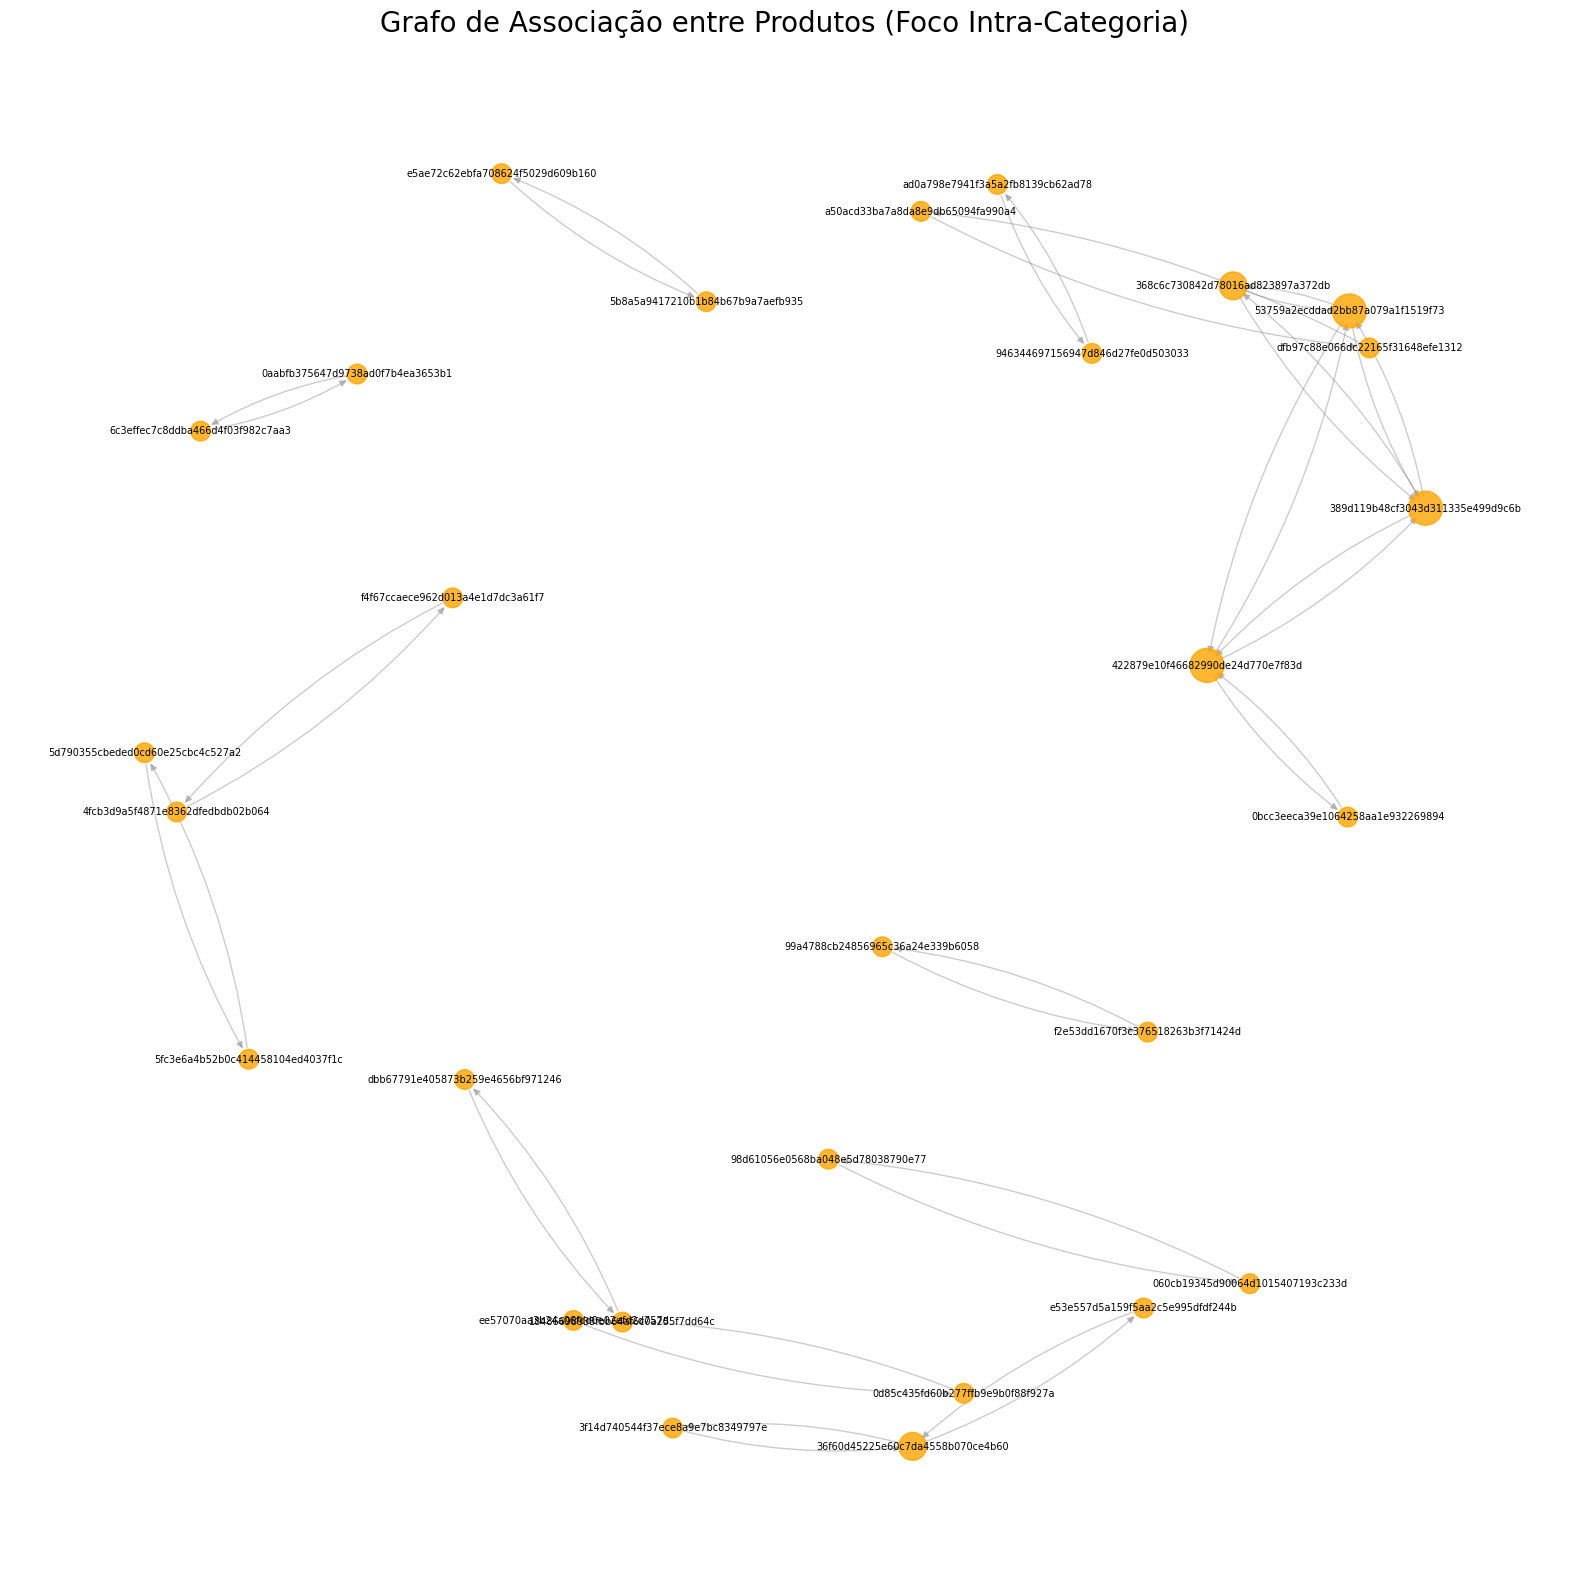

In [15]:


print("\n--- Iniciando Visualização: Grafo de Associação de Produtos (Intra-Categoria) ---")

# Verificar se 'rules' existe e tem as colunas de categoria
if ('rules' in locals() and not rules.empty and
    'Categoria_Antecedent' in rules.columns and 'Categoria_Consequent' in rules.columns):

    try:
        # --- 1. Filtrar Regras Intra-Categoria Fortes ---
        print("Passo 1: Filtrando regras intra-categoria...")
        # Manter apenas onde categoria do antecedente é IGUAL à do consequente
        intra_category_rules = rules[rules['Categoria_Antecedent'] == rules['Categoria_Consequent']].copy()

        # (Opcional) Filtrar ainda mais por uma métrica mínima para focar nas mais fortes
        min_lift_intra = 1.5 # Exemplo: Exigir um lift mínimo mesmo dentro da categoria
        intra_category_rules = intra_category_rules[intra_category_rules['lift'] >= min_lift_intra]
        print(f"Encontradas {len(intra_category_rules)} regras intra-categoria com lift >= {min_lift_intra}.")

        if not intra_category_rules.empty:
            # --- 2. Preparar Dados para Grafo de Produtos ---
            print("Passo 2: Preparando dados (extraindo Product IDs)...")
            # Filtrar para regras simples A->B para o grafo
            rules_simple_intra = intra_category_rules[(intra_category_rules['antecedents'].apply(len) == 1) &
                                                      (intra_category_rules['consequents'].apply(len) == 1)].copy()

            if rules_simple_intra.empty:
                 print("Nenhuma regra intra-categoria do tipo A->B encontrada após filtros.")
            else:
                print(f"Encontradas {len(rules_simple_intra)} regras intra-categoria A->B.")
                # Extrair Product IDs
                rules_simple_intra['Source_ProductID'] = rules_simple_intra['antecedents'].apply(lambda x: list(x)[0])
                rules_simple_intra['Target_ProductID'] = rules_simple_intra['consequents'].apply(lambda x: list(x)[0])

                # Selecionar colunas
                graph_data_prod = rules_simple_intra[['Source_ProductID', 'Target_ProductID', 'lift', 'confidence']].copy()

                # --- 3. Criar e Desenhar o Grafo ---
                print(f"Passo 3: Criando grafo com {len(graph_data_prod)} arestas (regras)...")
                G_intra = nx.from_pandas_edgelist(
                    graph_data_prod,
                    source='Source_ProductID',
                    target='Target_ProductID',
                    edge_attr=['lift', 'confidence'],
                    create_using=nx.DiGraph()
                )
                print(f"Grafo intra-categoria criado com {G_intra.number_of_nodes()} nós (produtos) e {G_intra.number_of_edges()} arestas.")

                if G_intra.number_of_nodes() > 0:
                    # Calcular grau e tamanho
                    degrees_intra = {node: G_intra.in_degree(node) + G_intra.out_degree(node) for node in G_intra.nodes()}
                    node_sizes_intra = [degrees_intra.get(node, 1) * 100 for node in G_intra.nodes()] # Ajuste multiplicador

                    # Calcular layout
                    print("Calculando layout...")
                    pos_intra = nx.spring_layout(G_intra, k=0.8, iterations=50, seed=42) # Ajuste k

                    # Desenhar
                    print("Desenhando o grafo...")
                    plt.figure(figsize=(20, 20)) # Tamanho grande

                    nx.draw_networkx_nodes(
                        G_intra, pos_intra, node_size=node_sizes_intra, node_color='orange', alpha=0.8
                    )
                    nx.draw_networkx_edges(
                        G_intra, pos_intra, alpha=0.4, edge_color='grey',
                        arrows=True, arrowstyle='-|>', arrowsize=10,
                        connectionstyle='arc3,rad=0.1'
                    )
                    # Rótulos são os Product IDs
                    nx.draw_networkx_labels(
                        G_intra, pos_intra, font_size=7, font_color='black'
                    )

                    plt.title("Grafo de Associação entre Produtos (Foco Intra-Categoria)", size=20)
                    plt.axis('off')
                    plt.show()
                else:
                    print("Grafo vazio, nada para desenhar.")
        else:
            print("Nenhuma regra intra-categoria restante após filtros para gerar o grafo.")

    except Exception as e:
        print(f"Erro ao gerar grafo intra-categoria por produto: {e}")

else:
    print("ERRO: DataFrame 'rules' (com categorias) não encontrado ou vazio.")

### O dataset público do Olist exisate uma limitação conhecida: 
- Ele não possuí uma coluna de nome_produto ou descrição do produto, apenas product_category_name. 
- Caso tivesse uma descrição, seria possível usar LLM's para inferir o nome do produto. 
- Analisando ademais análises no Kaggle, esse problema é comum. 

Desenhando o grafo com rótulos de categoria...
Usando nomes de categoria como rótulos.


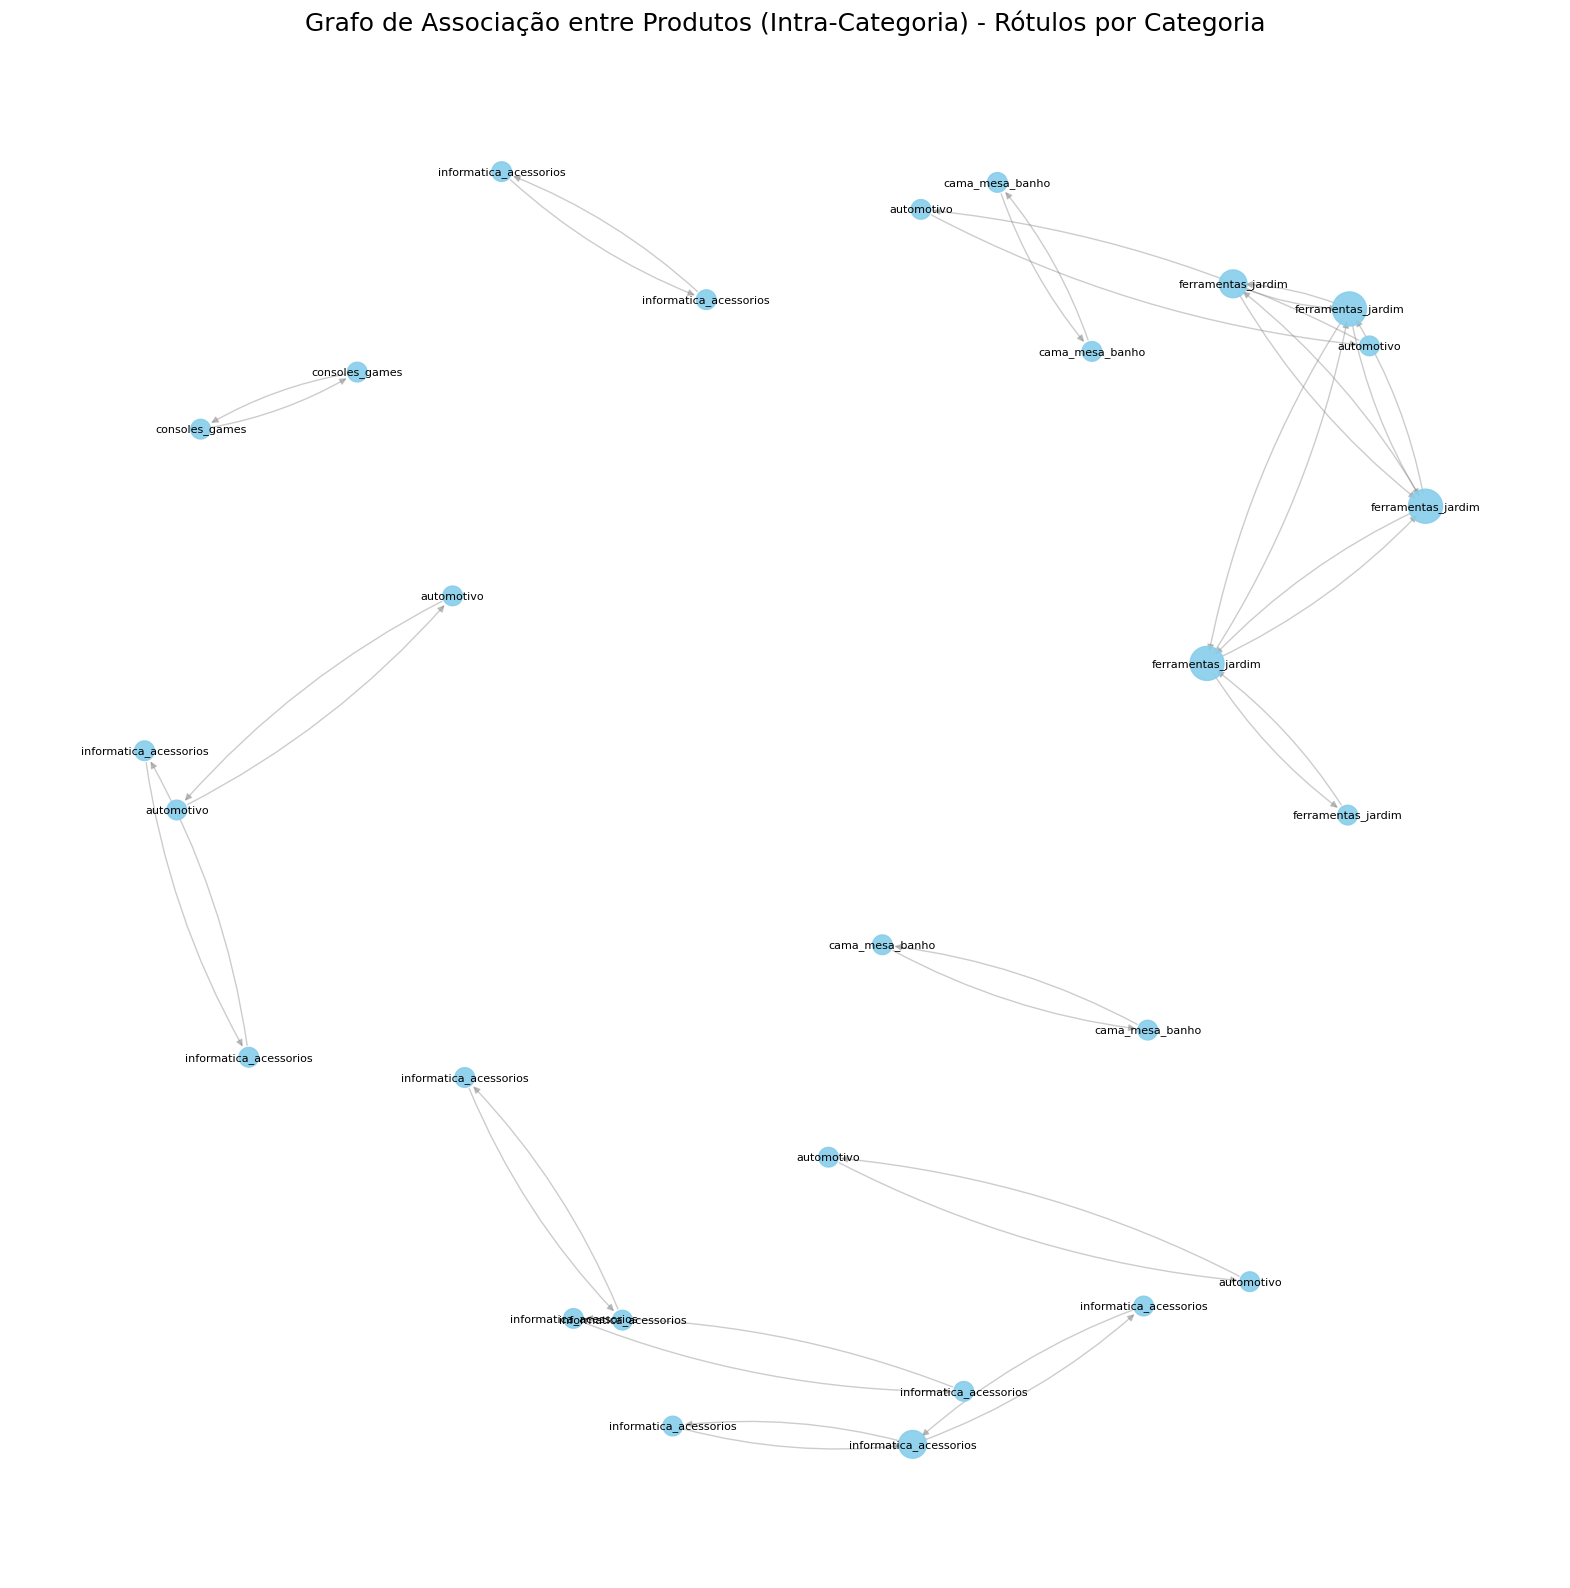

In [16]:
# ... (código anterior para criar G_intra, degrees_intra, node_sizes_intra, pos_intra) ...

# --- Desenhar o Grafo (com RÓTULOS DE CATEGORIA) ---
print("Desenhando o grafo com rótulos de categoria...")
plt.figure(figsize=(20, 20)) # Ajuste o tamanho se necessário

# Nós
nx.draw_networkx_nodes(
    G_intra, pos_intra, node_size=node_sizes_intra, node_color='skyblue', alpha=0.9 # Mudei a cor de volta
)
# Arestas
nx.draw_networkx_edges(
    G_intra, pos_intra, alpha=0.4, edge_color='grey',
    arrows=True, arrowstyle='-|>', arrowsize=10,
    connectionstyle='arc3,rad=0.1'
)

# *** MODIFICAÇÃO PARA RÓTULOS ***
# Criar um dicionário de rótulos: Node_ID -> Nome da Categoria
# Usando o mapa_categorias que criamos antes (verificar se está disponível no escopo)
if 'mapa_categorias' in locals():
    node_labels = {node: mapa_categorias.get(node, node) for node in G_intra.nodes()} # Usa ID se categoria não for encontrada
    print("Usando nomes de categoria como rótulos.")
else:
    node_labels = None # Desenhará os IDs se o mapa não for encontrado
    print("Aviso: mapa_categorias não encontrado. Usando Product IDs como rótulos.")

# Rótulos (Nomes das Categorias)
nx.draw_networkx_labels(
    G_intra, pos_intra,
    labels=node_labels, # <<< Passa o dicionário de rótulos
    font_size=8,        # <<< Ajuste o tamanho da fonte
    font_color='black'
)
# *** FIM DA MODIFICAÇÃO ***

plt.title("Grafo de Associação entre Produtos (Intra-Categoria) - Rótulos por Categoria", size=18)
plt.axis('off')
plt.show()